# Global Green Energy Part 4: Scale, Clustering & Energy Density 🔬

Shifting focus to the role of country size in energy systems, we explore how land area influences electricity production patterns. This analysis combines correlation mapping, clustering algorithms, and distribution analysis to understand whether bigger countries have fundamentally different energy transition challenges and opportunities.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans

# load in data
raw_data = pd.read_csv('../day18/global_sustainable_energy_data.csv')

#display(raw_data.sample(4))
#raw_data.info()

# data looks good, let's visuailise it. 
df = raw_data.copy()

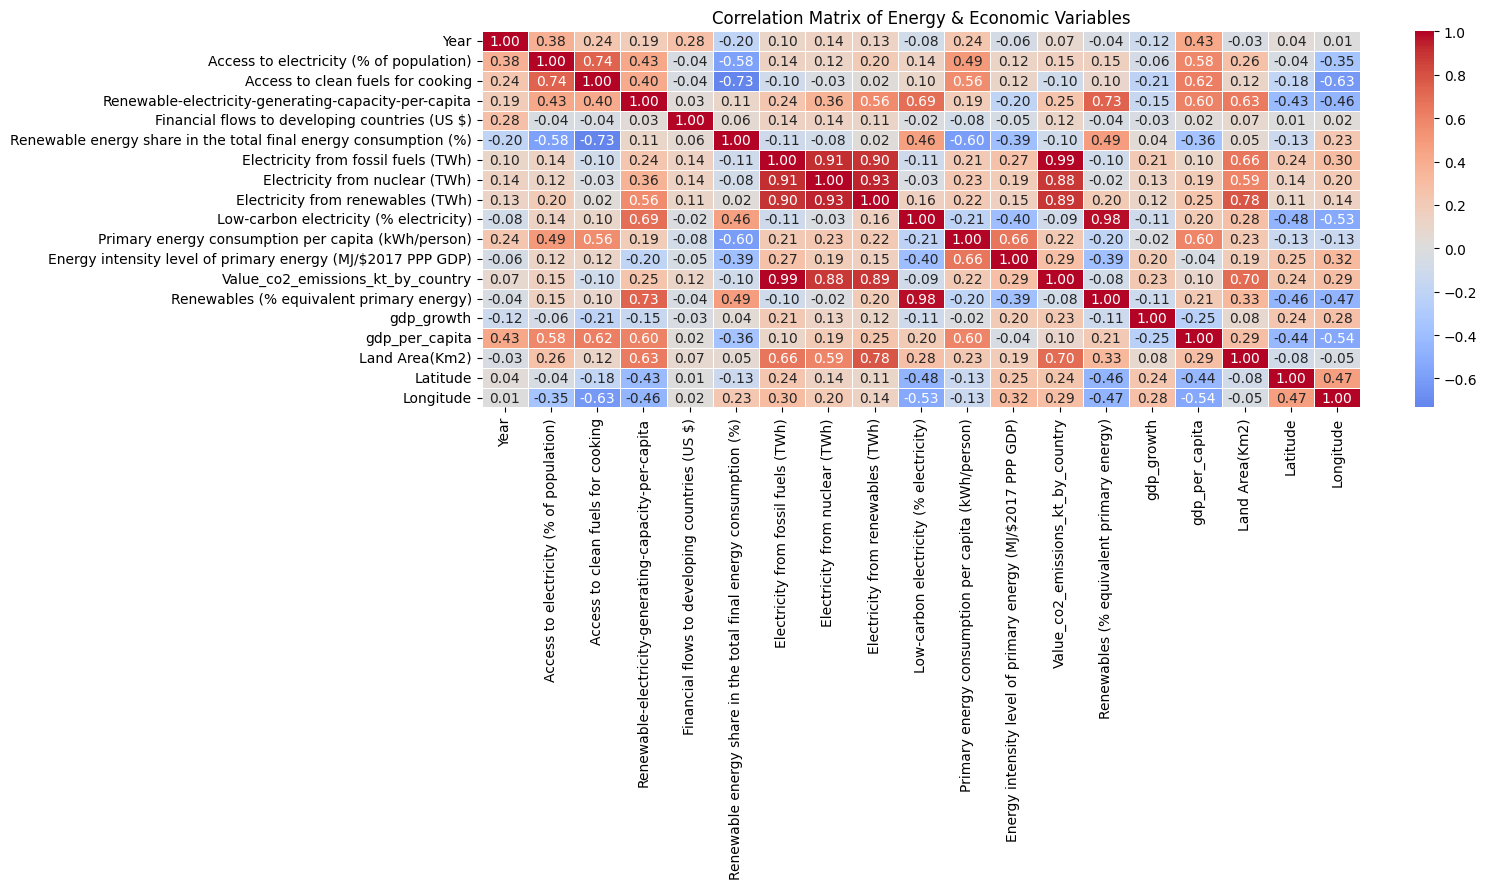

In [12]:
# Select only numeric columns
df_num = df.select_dtypes(include="number")

# Drop missing values (or fillna if needed)
df_corr = df_num.dropna()

# Correlation matrix
corr_matrix = df_corr.corr()

# Plot
plt.figure(figsize=(16, 9))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix of Energy & Economic Variables")
plt.tight_layout()
plt.show()

## Energy System Correlations: Finding Hidden Connections

The correlation matrix reveals the interconnected nature of global energy systems:
- **Systems thinking** - energy choices don't exist in isolation but are deeply interconnected with economic development, environmental outcomes, and social infrastructure
- **Policy intelligence** - understanding which variables move together helps identify strategic intervention points where changes in one area could catalyze broader transformations across the energy landscape

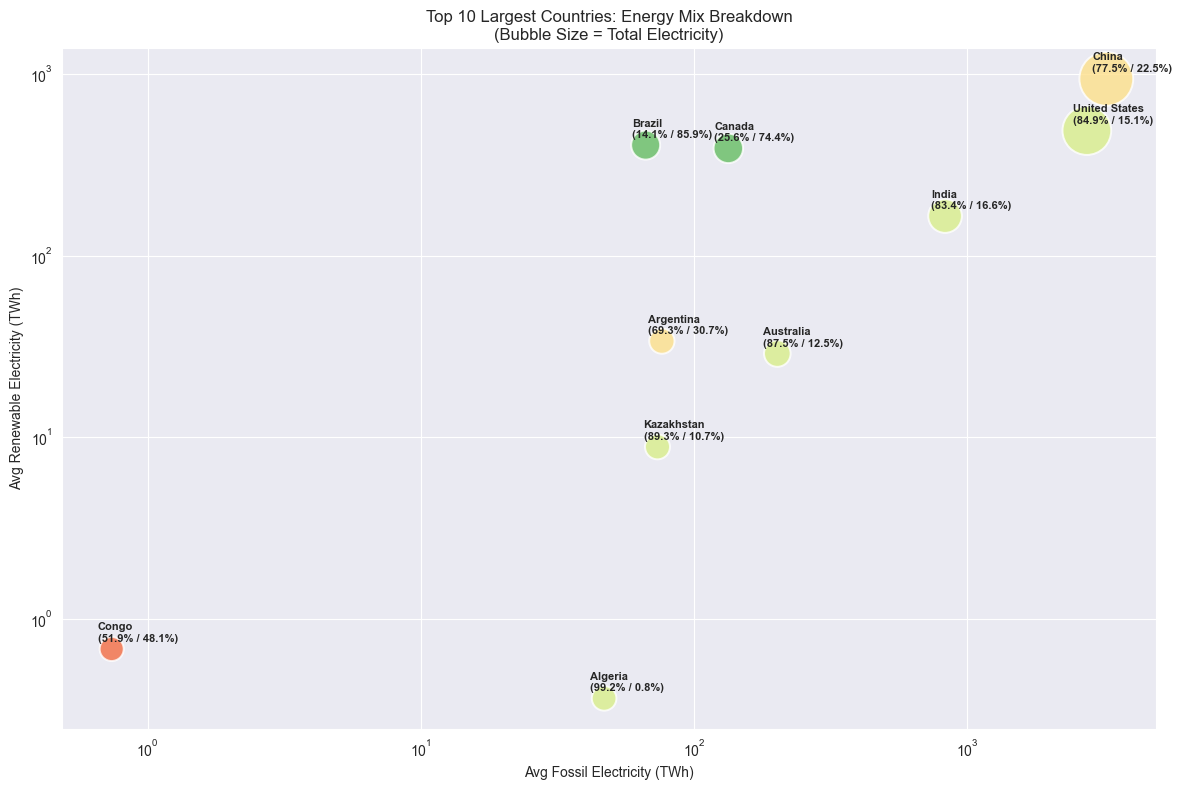

In [33]:
df_avg_grouped = df.groupby("Entity", as_index=False)[[
    "Electricity from fossil fuels (TWh)",
    "Electricity from renewables (TWh)",
    "Land Area(Km2)"
]].mean()

# Select top 10 countries by land area
top10 = df_avg_grouped.nlargest(10, "Land Area(Km2)")

# Calculate total electricity and fossil/renewable breakdown
top10["Total_Electricity"] = top10["Electricity from fossil fuels (TWh)"] + top10["Electricity from renewables (TWh)"]
top10["Fossil_Pct"] = (top10["Electricity from fossil fuels (TWh)"] / top10["Total_Electricity"] * 100).round(1)
top10["Renewable_Pct"] = (top10["Electricity from renewables (TWh)"] / top10["Total_Electricity"] * 100).round(1)

# Create energy mix categories
def categorize_energy_mix(fossil_pct):
    if fossil_pct >= 80:
        return "Fossil Dominant (80%+)"
    elif fossil_pct >= 60:
        return "Fossil Heavy (60-80%)"
    elif fossil_pct >= 40:
        return "Mixed (40-60%)"
    else:
        return "Renewable Heavy (<40% fossil)"

top10["Energy_Mix"] = top10["Fossil_Pct"].apply(categorize_energy_mix)

# Set style
sns.set_style("darkgrid")

# Plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=top10,
    x="Electricity from fossil fuels (TWh)",
    y="Electricity from renewables (TWh)",
    hue="Energy_Mix",
    size="Total_Electricity",
    sizes=(300, 1500),
    alpha=0.8,
    palette="RdYlGn_r"  # Red to Green palette (reversed so red = fossil dominant)
)

# Add country labels directly on points
for i, row in top10.iterrows():
    plt.annotate(
        f"{row['Entity']}\n({row['Fossil_Pct']}% / {row['Renewable_Pct']}%)",
        (row["Electricity from fossil fuels (TWh)"], row["Electricity from renewables (TWh)"]),
        xytext=(-10, 5),
        textcoords='offset points',
        fontsize=8,
        fontweight='bold',
        ha='left'
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Avg Fossil Electricity (TWh)")
plt.ylabel("Avg Renewable Electricity (TWh)")
plt.title("Top 10 Largest Countries: Energy Mix Breakdown\n(Bubble Size = Total Electricity)")

# Position legend outside plot area
# Remove legend
scatter.legend_.remove()

plt.tight_layout()
plt.show()

## Scale and Energy Mix: The Geography of Transition

Analyzing the world's largest countries by land area reveals critical patterns in energy transition:
- **Resource abundance paradox** - having vast land doesn't automatically translate to renewable leadership, suggesting that policy choices and economic structures matter more than geographic endowments
- **Development pathway diversity** - large countries demonstrate multiple viable approaches to balancing fossil and renewable electricity, challenging assumptions about one-size-fits-all energy strategies

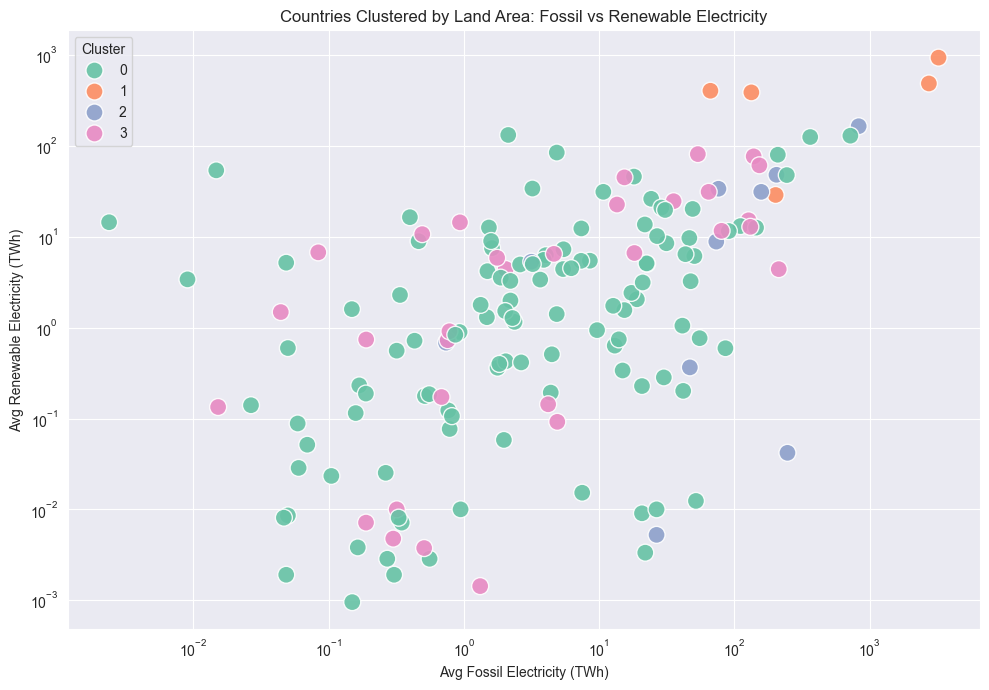

In [22]:
# Remove countries with missing Land Area
land_df = df[["Entity", "Land Area(Km2)"]].dropna()
land_df = land_df.groupby("Entity", as_index=False).mean()

# Cluster by land area
kmeans = KMeans(n_clusters=4, random_state=42)
land_df["Cluster"] = kmeans.fit_predict(land_df[["Land Area(Km2)"]])

# Merge clusters back to main DataFrame
df_clustered = df.merge(land_df[["Entity", "Cluster"]], on="Entity")

# Average fossil vs renewable electricity per country & cluster
avg_power = df_clustered.groupby(["Entity", "Cluster"], as_index=False)[[
    "Electricity from fossil fuels (TWh)",
    "Electricity from renewables (TWh)"
]].mean()

# Scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=avg_power,
    x="Electricity from fossil fuels (TWh)",
    y="Electricity from renewables (TWh)",
    hue="Cluster",
    palette="Set2",
    s=150,
    alpha=0.9
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Avg Fossil Electricity (TWh)")
plt.ylabel("Avg Renewable Electricity (TWh)")
plt.title("Countries Clustered by Land Area: Fossil vs Renewable Electricity")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


## Clustering Insights: Beyond Simple Categories

Machine learning clustering by land area uncovers energy system patterns that transcend obvious geographic groupings:
- **Emergent patterns** - countries cluster not just by size but by how they leverage their scale for different energy strategies, revealing that similar-sized nations can pursue radically different energy pathways
- **Strategic positioning** - the clustering suggests that countries within similar size categories face comparable challenges and opportunities, potentially enabling targeted policy learning and technology transfer

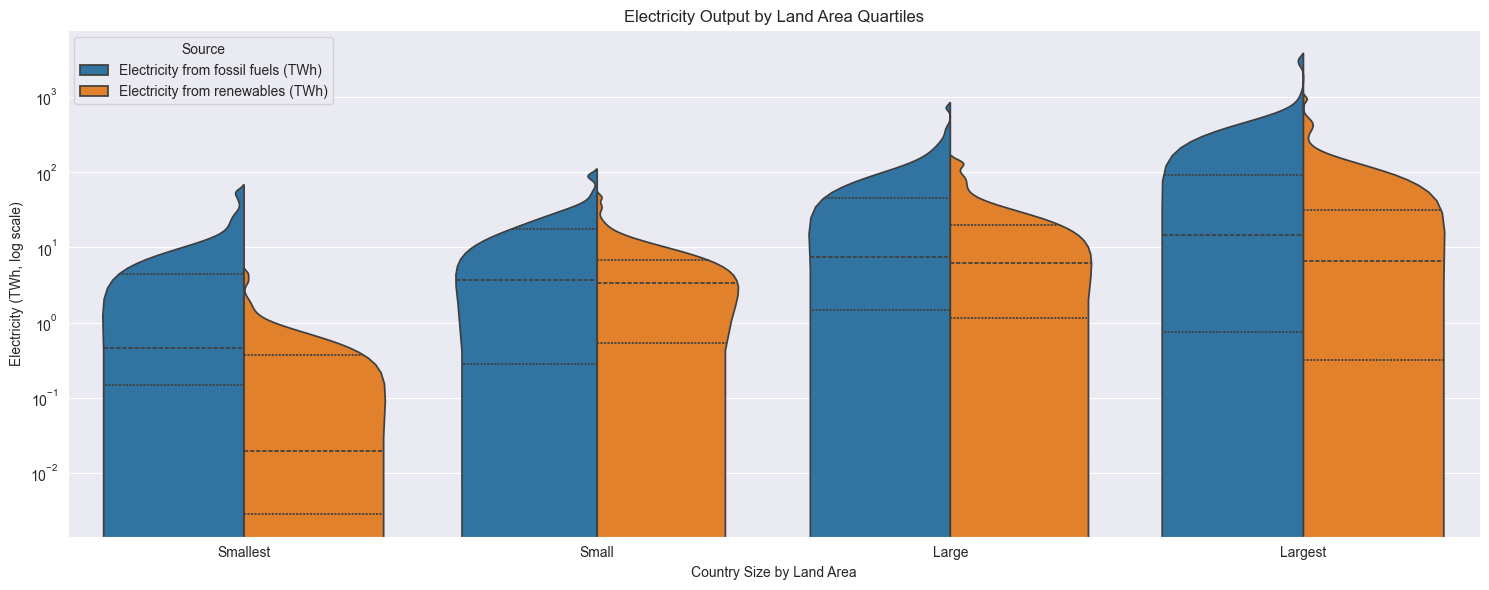

In [41]:
# Drop rows with missing required columns
df_quart = df.dropna(subset=[
    "Entity", "Land Area(Km2)",
    "Electricity from renewables (TWh)",
    "Electricity from fossil fuels (TWh)"
])

# Group by country to get average per entity
df_avg = df_quart.groupby("Entity", as_index=False).agg({
    "Land Area(Km2)": "mean",
    "Electricity from renewables (TWh)": "mean",
    "Electricity from fossil fuels (TWh)": "mean"
})

# Bin countries into land area quartiles
df_avg["Size Group"] = pd.qcut(df_avg["Land Area(Km2)"], 4, labels=["Smallest", "Small", "Large", "Largest"])

# Melt for multi-source plotting
df_melted = df_avg.melt(
    id_vars=["Entity", "Size Group"],
    value_vars=["Electricity from fossil fuels (TWh)", "Electricity from renewables (TWh)"],
    var_name="Source",
    value_name="Electricity (TWh)"
)

# Violin plot
plt.figure(figsize=(15, 6))
sns.violinplot(
    data=df_melted,
    x="Size Group", y="Electricity (TWh)", hue="Source",
    split=True, inner="quart", density_norm='width',
)
plt.yscale("log")
plt.title("Electricity Output by Land Area Quartiles")
plt.xlabel("Country Size by Land Area")
plt.ylabel("Electricity (TWh, log scale)")
plt.tight_layout()
plt.show()



## Distribution Analysis: The Shape of Energy Inequality

Violin plots reveal the full distribution of energy production across country size categories:
- **Power concentration** - energy production is highly skewed even within size categories, with a few outliers dominating total output while most countries operate at much smaller scales
- **Transition accessibility** - the wide distributions suggest that renewable transitions are feasible across the entire spectrum of country sizes, not just for energy superpowers or small innovators

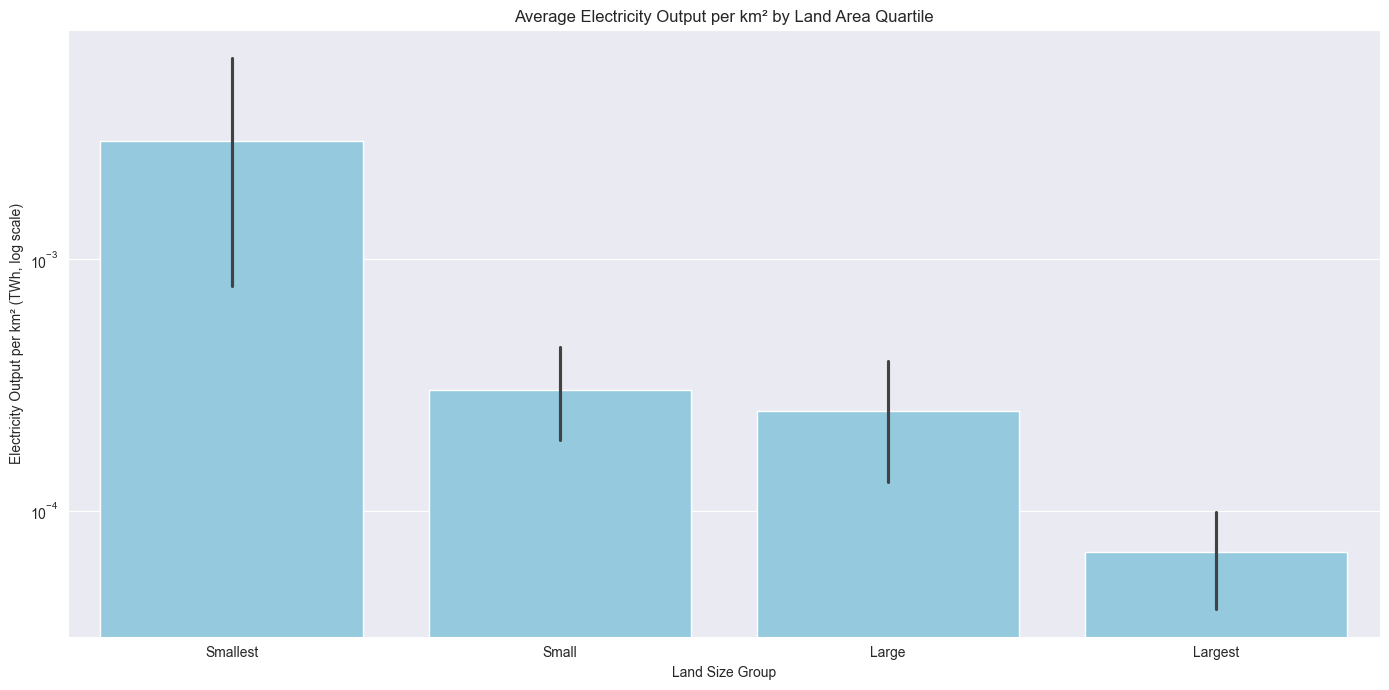

In [44]:
# Step 1: Collapse to one row per country (mean values)
df_mean = raw_data.groupby("Entity", as_index=False).mean(numeric_only=True)

# Step 2: Calculate total electricity output
df_mean["Total Electricity (TWh)"] = (
    df_mean["Electricity from fossil fuels (TWh)"] +
    df_mean["Electricity from renewables (TWh)"]
)

# Step 3: Normalize by land area (TWh per km²)
df_mean["Electricity per km²"] = df_mean["Total Electricity (TWh)"] / df_mean["Land Area(Km2)"]
# Step 4: Assign land area quartile groups
df_mean["Land Size Group"] = pd.qcut(df_mean["Land Area(Km2)"], q=4,
                                      labels=["Smallest", "Small", "Large", "Largest"])

# Step 5: Plot average electricity/km² by group
plt.figure(figsize=(14, 7))
sns.barplot(data=df_mean, x="Land Size Group", y="Electricity per km²", color="skyblue")
plt.yscale("log")
plt.ylabel("Electricity Output per km² (TWh, log scale)")
plt.title("Average Electricity Output per km² by Land Area Quartile")
plt.tight_layout()
plt.show()


# Synthesis: Toward Data-Driven Energy Policy

## Key Analytical Insights

Our analysis reveals critical insights for understanding and accelerating renewable transitions:

### 1. **Scale Effects Are Complex**
Larger countries don't automatically lead in renewable adoption. The highest electricity density occurs in smaller, developed nations, suggesting policy frameworks matter more than geographic scale.

### 2. **Multiple Transition Pathways**
Even among the world's largest nations, we see the full spectrum from fossil-dominant to renewable-heavy energy mixes, indicating that transition strategies must be tailored to local contexts.

### 3. **Clustering Reveals Strategic Opportunities**
Machine learning clustering uncovers hidden patterns in how similar-sized countries approach energy challenges, suggesting opportunities for targeted policy learning and technology transfer.

### 4. **Energy Inequality Persists**
Distribution analysis shows extreme inequality in energy production even within size categories, with profound implications for climate policy interventions.

## Policy Implications

### **For Large Countries**
Multiple viable pathways to renewable leadership exist, but success depends more on policy coherence than resource abundance.

### **For Smaller Nations**
High electricity density demonstrates that scale isn't destiny - focused renewable investments can achieve outsized impacts relative to land area.

### **For International Cooperation**
Cooperation should be organized around shared structural characteristics rather than just geographic proximity or political alliances.

## Future Research Directions

- **Temporal dynamics**: How do these patterns change as renewable technologies mature?
- **Economic integration**: How do trade relationships interact with energy mix choices?
- **Policy intervention analysis**: Which tools are most effective for different country clusters?

The data suggests successful energy transitions require understanding country-specific contexts combined with strategic learning from structurally similar nations.